# Mapped modules

`xclim` gives users the ability to generate their own modules as one-to-one mappings with the existing indices library. These mappings can help in emulating existing libraries (such as ICCLIM), with the added benefit of CF-compliant metadata, multilingual metadata support, and optimized calculations using federated resources (using Dask). This can be used for example to tailor existing indices with predefined thresholds without having to rewrite indices.

Presently, xclim is capable of approximating the indices developed in ICCLIM (https://icclim.readthedocs.io/en/latest/intro.html) and is open to contributions of new indices and library mappings.

This notebook serves as an example of how one might go about creating their own library of mapped indices.

We'll begin by examining how the mapped modules behave

In [1]:
# importing libraries

import xarray as xr
xr.set_options(display_style='html')

import xclim
from xclim import indices
from xclim import icclim
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

(array([ 11.,  60., 110., 119., 124.,  86.,  69.,  75.,  53.,  23.]),
 array([276.3725 , 277.90976, 279.447  , 280.98425, 282.52148, 284.05875,
        285.596  , 287.13324, 288.6705 , 290.20773, 291.745  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

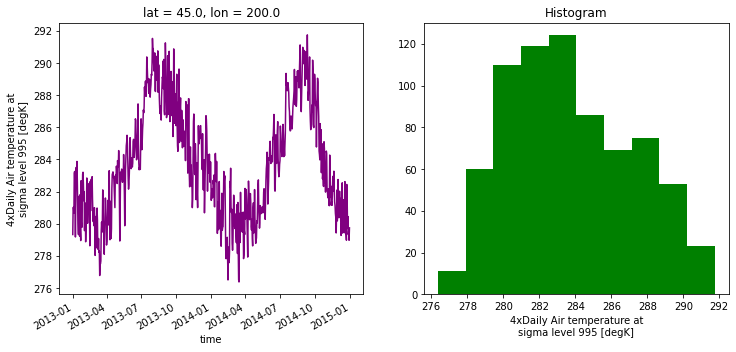

In [2]:
ds = xr.tutorial.open_dataset('air_temperature')
daily_tas = ds.air.resample(time='D').mean(keep_attrs=True)

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

daily_tas.sel(lat=45, lon=-71, method="nearest").plot(ax=axes[0], color="purple")
daily_tas.sel(lat=45, lon=-71, method="nearest").plot.hist(ax=axes[1], color="green")


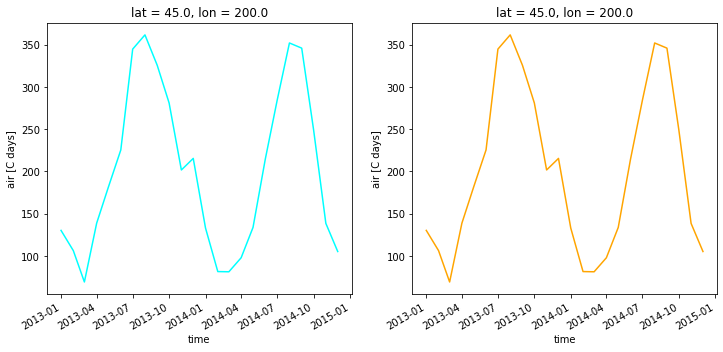

In [3]:
# The following comparisons for Growing Degree Days from xclim.indices and xclim.icclim should be the same.

gdd_xclim = indices.growing_degree_days(daily_tas, freq="MS").compute()
gdd_icclim = icclim.GD4(daily_tas, freq="MS").compute()

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

gdd_icclim.sel(lat=45, lon=-71, method="nearest").plot(ax=axes[0], color="cyan")
gdd_xclim.sel(lat=45, lon=-71, method="nearest").plot(ax=axes[1], color="orange")


In [4]:
# Assert that the values are the same between both the original and the mapping of the indice.

if np.alltrue(gdd_icclim.values == gdd_xclim.values):
    print("Datasets hold the same values!")

Datasets hold the same values!


In [5]:
# Let's look more closely at the ICCLIM module
from xclim import icclim
import inspect

print(icclim.__doc__)
for i in inspect.getmembers(icclim):
    if i[0][0] != '_':
        print(f"{i[0]} : {i[1]}")


            ICCLIM indices
            The European Climate Assessment & Dataset project (`ECAD`_) defines
            a set of 26 core climate indices. Those have been made accessible
            directly in xclim through their ECAD name for compatibility. However,
            the methods in this module are only wrappers around the corresponding
            methods of  `xclim.indices`. Note that none of the checks performed by
            the `xclim.utils.Indicator` class (like with `xclim.atmos` indicators)
            are performed in this module.

            .. _ECAD: https://www.ecad.eu/
            
CDD : <function maximum_consecutive_dry_days at 0x7fa3b17541f0>
CFD : <function consecutive_frost_days at 0x7fa3b17994c0>
CSDI : <function cold_spell_duration_index at 0x7fa3b17748b0>
CSU : <function maximum_consecutive_tx_days at 0x7fa3b1754550>
CWD : <function maximum_consecutive_wet_days at 0x7fa3b17404c0>
DTR : <function daily_temperature_range at 0x7fa3b1774ca0>
ETR : <function

## Creating your own custom mapped module

As we can see from the layout of ICCLIM, the module is effectively several wrapped instances of existing indices, with a majority comprising unchanged indices and several composed of indices with different threshold values.

These mappings can be found in `xclim/xclim/__init__.py` and can be create using the `build_module` function. A mapping requires two types of information:

* A dictionary of mapped indices
* A docstring, usually written in ReStructuredText format

Let's try creating our own custom indices for our specific purposes:

In [6]:
from xclim.indicators import build_module
from xclim.core.utils import wrapped_partial

def awesome_module(mode: str = "ignore"):
    mapping = dict(
        egg_cooking_season=wrapped_partial(indices.maximum_consecutive_tx_days, thresh="35 degC"),
        precipitation_above_14mm=wrapped_partial(indices.wetdays, thresh="14.0 mm/day"),
        sweater_weather=indices.tg_min
    )
    mod = build_module(
        "xclim.awesome",
        mapping,
        doc="""
            =========================
            My Awesome Custom indices
            =========================
            There are only 3 indices that really matter when you come down to brass tacks.
            This mapping library exposes them to users who want to perform real deal 
            climate science. Note that none of the checks performed by the `xclim.utils.Indicator` 
            class (like with `xclim.atmos` indicators) are performed in this module.

            """,
        mode=mode,
    )
    return mod

AWESOME = awesome_module()

In [7]:
# Let's look at our new awesome module
from xclim import awesome
import inspect

print(awesome.__doc__)
for i in inspect.getmembers(awesome):
    if i[0][0] != '_':
        print(f"{i[0]} : {i[1]}")


            My Awesome Custom indices
            There are only 3 indices that really matter when you come down to brass tacks.
            This mapping library exposes them to users who want to perform real deal 
            climate science. Note that none of the checks performed by the `xclim.utils.Indicator` 
            class (like with `xclim.atmos` indicators) are performed in this module.

            
egg_cooking_season : <function maximum_consecutive_tx_days at 0x7fa3af662c10>
precipitation_above_14mm : <function wetdays at 0x7fa3af662b80>
sweater_weather : <function tg_min at 0x7fa3b1790700>


(array([ 77., 204., 153.,  69.,  67.,  85., 115., 147., 194., 214.]),
 array([222.8175 , 230.38025, 237.94301, 245.50575, 253.06851, 260.63126,
        268.194  , 275.75674, 283.31952, 290.88226, 298.445  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

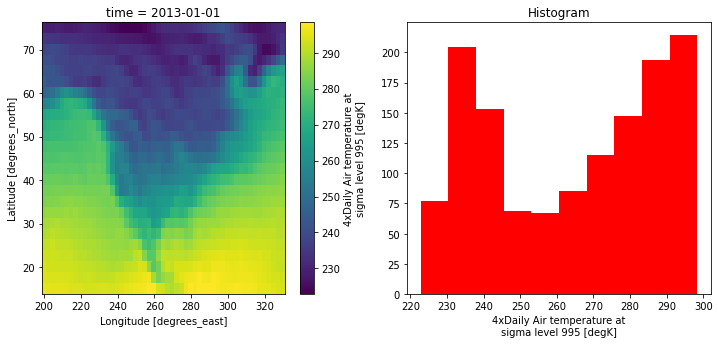

In [8]:
sweater_weather_day_temperature = awesome.sweater_weather(daily_tas).compute()

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

sweater_weather_day_temperature.isel(time=0).plot(ax=axes[0])
sweater_weather_day_temperature.isel(time=0).plot.hist(ax=axes[1], color="red")


We can also use this to recreate existing indice libraries such as the indicators used by the Prairie Climate Centre's Climate Atlas of Canada (https://climateatlas.ca/variables). 

Here's how we could go about creating a good deal of them:

In [9]:
def __build_pcc(mode: str = "warn"):
    
    # The following indices are not implemented here:
        # average_length_of_heat_waves
        # corn_heat_units
        # maximum_temperature
        # minimum_temperature

    mapping = dict(
        coldest_minimum_temperature=indices.tn_min,
        cooling_degree_days=indices.cooling_degree_days,
        date_of_first_fall_frost=wrapped_partial(
            indices.growing_season_end, thresh="0 degC", mid_date="07-15", window=1
        ),
        date_of_last_spring_frost=indices.last_spring_frost,
        days_above_32_celsius=wrapped_partial(
            indices.tx_days_above, thresh="32.0 degC"
        ),
        days_above_34_celsius=wrapped_partial(
            indices.tx_days_above, thresh="34.0 degC"
        ),
        dry_days=indices.dry_days,
        freeze_thaw_cycles=wrapped_partial(
            indices.daily_freezethaw_cycles,
            thresh_tasmax="0 degC",
            thresh_tasmin="-1.0 degC",
        ),
        freezing_degree_days=wrapped_partial(
            indices.heating_degree_days, thresh="0 degC"
        ),
        frost_days=indices.frost_days,
        frost_free_season=indices.maximum_consecutive_frost_free_days,
        growing_degree_days_base_4_celsius=wrapped_partial(
            indices.growing_degree_days, thresh="4.0 degC"
        ),
        growing_degree_days_base_5_celsius=wrapped_partial(
            indices.growing_degree_days, thresh="5.0 degC"
        ),
        growing_degree_days_base_10_celsius=wrapped_partial(
            indices.growing_degree_days, thresh="10.0 degC"
        ),
        growing_degree_days_base_15_celsius=wrapped_partial(
            indices.growing_degree_days, thresh="15.0 degC"
        ),
        heating_degree_days=wrapped_partial(
            indices.heating_degree_days, thresh="18.0 degC"
        ),
        heavy_precipitation_days_10mm=wrapped_partial(
            indices.wetdays, thresh="10.0 mm/day"
        ),
        heavy_precipitation_days_20mm=wrapped_partial(
            indices.wetdays, thresh="20.0 mm/day"
        ),
        hot_season=wrapped_partial(
            indices.maximum_consecutive_tx_days, thresh="30.0 degC"
        ),
        icing_days=indices.ice_days,
        longest_spell_of_30_celsius_days=indices.hot_spell_max_length,
        max_1_day_precipitation=indices.max_1day_precipitation_amount,
        max_3_day_precipitation=wrapped_partial(
            indices.max_n_day_precipitation_amount, window=3
        ),
        max_5_day_precipitation=wrapped_partial(
            indices.max_n_day_precipitation_amount, window=5
        ),
        mean_temperature=indices.tas,
        mild_winter_days=wrapped_partial(indices.tn_days_below, thresh="-5.0 degC"),
        number_of_heat_waves=indices.hot_spell_frequency,
        summer_days=indices.tx_days_above,
        tropical_nights=wrapped_partial(
            indices.tropical_nights
        ),  
        very_cold_days=wrapped_partial(indices.tn_days_below, thresh="-30.0 degC"),
        very_hot_days=wrapped_partial(indices.tx_days_above, thresh="-30.0 degC"),
        warmest_maximum_temperature=indices.tx_max,
        wet_days=wrapped_partial(indices.wetdays, thresh="0.2 mm/day"),
        winter_days=wrapped_partial(indices.tn_days_below, thresh="-15.0 degC"),
    )
    mod = build_module(
        "xclim.pcc",
        mapping,
        doc="""
            ==============================
            Prairie Climate Centre indices
            ==============================
            The Prairie Climate Centre (`PCC`_) defines a set of 23 core climate `indices`_.
            They have been made accessible directly in xclim by their climate atlas names.
            However, the methods in this module are only wrappers around the corresponding
            methods of `xclim.indices`. Note that none of the checks performed by
            the `xclim.utils.Indicator` class (like with `xclim.atmos` indicators)
            are performed in this module.

            .. _PCC: http://prairieclimatecentre.ca/
            .. _indices: https://climateatlas.ca/variables
            """,
        mode=mode,
    )
    return mod

PCC = __build_pcc()

In [10]:
from xclim import pcc
import inspect

print(pcc.__doc__)
for i in inspect.getmembers(pcc):
    if i[0][0] != '_':
        print(f"{i[0]} : {i[1]}")


            Prairie Climate Centre indices
            The Prairie Climate Centre (`PCC`_) defines a set of 23 core climate `indices`_.
            They have been made accessible directly in xclim by their climate atlas names.
            However, the methods in this module are only wrappers around the corresponding
            methods of `xclim.indices`. Note that none of the checks performed by
            the `xclim.utils.Indicator` class (like with `xclim.atmos` indicators)
            are performed in this module.

            .. _PCC: http://prairieclimatecentre.ca/
            .. _indices: https://climateatlas.ca/variables
            
coldest_minimum_temperature : <function tn_min at 0x7fa3b1790c10>
cooling_degree_days : <function cooling_degree_days at 0x7fa3b1740670>
date_of_first_fall_frost : <function growing_season_end at 0x7fa3af5af310>
date_of_last_spring_frost : <function last_spring_frost at 0x7fa3b1740ee0>
days_above_32_celsius : <function tx_days_above at 0x7fa3af5a

In [11]:
# Let's see what the documentation will look like

help(pcc)

Help on module xclim.pcc in xclim:

NAME
    xclim.pcc

DESCRIPTION
    Prairie Climate Centre indices
    The Prairie Climate Centre (`PCC`_) defines a set of 23 core climate `indices`_.
    They have been made accessible directly in xclim by their climate atlas names.
    However, the methods in this module are only wrappers around the corresponding
    methods of `xclim.indices`. Note that none of the checks performed by
    the `xclim.utils.Indicator` class (like with `xclim.atmos` indicators)
    are performed in this module.
    
    .. _PCC: http://prairieclimatecentre.ca/
    .. _indices: https://climateatlas.ca/variables

FUNCTIONS
    coldest_minimum_temperature = tn_min(tasmin: xarray.core.dataarray.DataArray, freq: str = 'YS')
        Lowest minimum temperature.
        
        Minimum of daily minimum temperature.
        
        Parameters
        ----------
        tasmin : xarray.DataArray
          Minimum daily temperature [℃] or [K]
        freq : str
          Res